In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
# default_exp interpret

In [ ]:
#export
from fastai.data.all import *
from fastai.optimizer import *
from fastai.learner import *
from fastai.tabular.core import *
import sklearn.metrics as skm

In [ ]:
#hide
from fastai.test_utils import *
from nbdev.showdoc import *

# Interpretation of Predictions

> Classes to build objects to better interpret predictions of a model

In [ ]:
#hide
from fastai.vision.all import *
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSubsetSplitter(.1,.1, seed=42),
                  get_y=parent_label)
test_dls = mnist.dataloaders(untar_data(URLs.MNIST_SAMPLE), bs=8)
test_learner = cnn_learner(test_dls, resnet18)

In [ ]:
#export
@typedispatch
def plot_top_losses(x, y, *args, **kwargs):
    raise Exception(f"plot_top_losses is not implemented for {type(x)},{type(y)}")

In [ ]:
#export
_all_ = ["plot_top_losses"]

In [ ]:
#export
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, learn, dl, losses, act=None): 
        store_attr()

    def __getitem__(self, idxs):
        "Return inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        items = getattr(self.dl.items, 'iloc', L(self.dl.items))[idxs]
        tmp_dl = self.learn.dls.test_dl(items, with_labels=True, process=not isinstance(self.dl, TabDataLoader))
        inps,preds,targs,decoded = self.learn.get_preds(dl=tmp_dl, with_input=True, with_loss=False, 
                                                        with_decoded=True, act=self.act, reorder=False)
        return inps, preds, targs, decoded, self.losses[idxs]

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx].new(shuffle=False, drop_last=False)
        _,_,losses = learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=False,
                                     with_preds=False, with_targs=False, act=act)
        return cls(learn, dl, losses, act)

    def top_losses(self, k=None, largest=True, items=False):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`). Optionally include items."
        losses, idx = self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
        if items: return losses, idx, getattr(self.dl.items, 'iloc', L(self.dl.items))[idx]
        else:     return losses, idx

    def plot_top_losses(self, k, largest=True, **kwargs):
        "Show `k` largest(/smallest) preds and losses. `k` may be int, list, or `range` of desired results."
        if is_listy(k) or isinstance(k, range):
            losses, idx = (o[k] for o in self.top_losses(None, largest))
        else: 
            losses, idx = self.top_losses(k, largest)
        inps, preds, targs, decoded, _ = self[idx]
        inps, targs, decoded = tuplify(inps), tuplify(targs), tuplify(decoded)
        x, y, its = self.dl._pre_show_batch(inps+targs)
        x1, y1, outs = self.dl._pre_show_batch(inps+decoded, max_n=len(idx))
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses, **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

    def show_results(self, idxs, **kwargs):
        "Show predictions and targets of `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        inps, _, targs, decoded, _ = self[idxs]
        b = tuplify(inps)+tuplify(targs)
        self.dl.show_results(b, tuplify(decoded), max_n=len(idxs), **kwargs)

In [ ]:
show_doc(Interpretation, title_level=3)

<h3 id="Interpretation" class="doc_header"><code>class</code> <code>Interpretation</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Interpretation</code>(**`learn`**, **`dl`**, **`losses`**, **`act`**=*`None`*)

Interpretation base class, can be inherited for task specific Interpretation classes

`Interpretation` is a helper base class for exploring predictions from trained models. It can be inherited for task specific interpretation classes, such as `ClassificationInterpretation`. `Interpretation` is memory efficient and should be able to process any sized dataset, provided the hardware could train the same model.

> Note: `Interpretation` is memory efficient due to generating inputs, predictions, targets, decoded outputs, and losses for each item on the fly, using batch processing where possible.

In [ ]:
show_doc(Interpretation.from_learner, title_level=3)

<h3 id="Interpretation.from_learner" class="doc_header"><code>Interpretation.from_learner</code><a href="__main__.py#L17" class="source_link" style="float:right">[source]</a></h3>

> <code>Interpretation.from_learner</code>(**`learn`**, **`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`act`**=*`None`*)

Construct interpretation object from a learner

In [ ]:
show_doc(Interpretation.top_losses, title_level=3)

<h3 id="Interpretation.top_losses" class="doc_header"><code>Interpretation.top_losses</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h3>

> <code>Interpretation.top_losses</code>(**`k`**=*`None`*, **`largest`**=*`True`*, **`items`**=*`False`*)

`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`). Optionally include items.

With the default of `k=None`, `top_losses` will return the entire dataset's losses. `top_losses` can optionally include the input items for each loss, which is usually a file path or Pandas `DataFrame`.

In [ ]:
show_doc(Interpretation.plot_top_losses, title_level=3)

<h3 id="Interpretation.plot_top_losses" class="doc_header"><code>Interpretation.plot_top_losses</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h3>

> <code>Interpretation.plot_top_losses</code>(**`k`**, **`largest`**=*`True`*, **\*\*`kwargs`**)

Show `k` largest(/smallest) preds and losses. `k` may be int, list, or `range` of desired results.

To plot the first 9 top losses:
```python
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)
```
Then to plot the 7th through 16th top losses:
```python
interp.plot_top_losses(range(7,16))
```

In [ ]:
show_doc(Interpretation.show_results, title_level=3)

<h3 id="Interpretation.show_results" class="doc_header"><code>Interpretation.show_results</code><a href="__main__.py#L47" class="source_link" style="float:right">[source]</a></h3>

> <code>Interpretation.show_results</code>(**`idxs`**, **\*\*`kwargs`**)

Show predictions and targets of `idxs`

Like `Learner.show_results`, except can pass desired index or indicies for item(s) to show results from.

In [ ]:
#hide
interp = Interpretation.from_learner(test_learner)
x, y, out = [], [], []
for batch in test_learner.dls.valid:
    x += batch[0]
    y += batch[1]
    out += test_learner.model(batch[0])
x,y,out = torch.stack(x), torch.stack(y, dim=0), torch.stack(out, dim=0)
inps, preds, targs, decoded, losses = interp[:]
test_eq(inps, to_cpu(x))
test_eq(targs, to_cpu(y))
loss = torch.stack([test_learner.loss_func(p,t) for p,t in zip(out,y)], dim=0)
test_close(losses, to_cpu(loss))

In [ ]:
#def plot_top_losses(self, k, largest=True, **kwargs):
k=9
largest=True

In [ ]:
"Show `k` largest(/smallest) preds and losses. `k` may be int, list, or `range` of desired results."
if is_listy(k) or isinstance(k, range):
    losses, idx = (o[k] for o in interp.top_losses(None, largest))
else: 
    losses, idx = interp.top_losses(k, largest)

In [ ]:
losses

TensorBase([1.6696, 1.6164, 1.6111, 1.5664, 1.5506, 1.5351, 1.5175, 1.4874, 1.4843])

In [ ]:
idx

TensorBase([ 281,  744, 1063,  307, 1298,  212,  726, 1310,  502])

In [ ]:
inps, preds, targs, decoded, _ = interp[idx]

In [ ]:
inps, targs, decoded = tuplify(inps), tuplify(targs), tuplify(decoded)

In [ ]:
x, y, its = interp.dl._pre_show_batch(inps+targs)

In [ ]:
x1, y1, outs = interp.dl._pre_show_batch(inps+decoded, max_n=len(idx))

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y:TensorCategory, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), nrows=nrows, ncols=ncols, figsize=figsize, title='Prediction|Actual Class\nPredicted|Actual Probability\nLoss')
    for ax,s,o,r,l,y_idx in zip(axs, samples, outs, raws, losses, y):
        s[0].show(ctx=ax, **kwargs)
#        ax.set_title(f'{o[0]} | {s[1]}\n{r.max().item():.2f} | {r[y_idx]:.2f}\n{l.item():.2f}')
        ax.set_title(f'longer class name | longer other class name\n{r.max().item():.2f} | {r[y_idx]:.2f}\n{l.item():.2f}')
    plt.tight_layout()

In [ ]:
interp[0][0].show()

RuntimeError: number of dims don't match in permute

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y_targ_idx:TensorCategory, y_pred_idx, vocab, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axs = get_grid(len(x), nrows=nrows, ncols=ncols, figsize=figsize, title='Prediction|Actual Class\nPredicted|Actual Probability\nLoss')
    for ax,x_,y_a,y_p,r,l in zip(axs, x, y_targ_idx, y_pred_idx, raws, losses):
        x_.show(ctx=ax, **kwargs)
        ax.set_title(f'{vocab[y_p]} | {vocab[y_a]}\n{r[y_p]:.2f} | {r[y_a]:.2f}\n{l.item():.2f}')
    plt.tight_layout()

In [ ]:
dl.decode('3')

TypeError: isinstance() arg 2 must be a type or tuple of types

In [ ]:
dl.vocab[0]

'3'

In [ ]:
inps, preds, targs, decoded, _ = interp[idx]

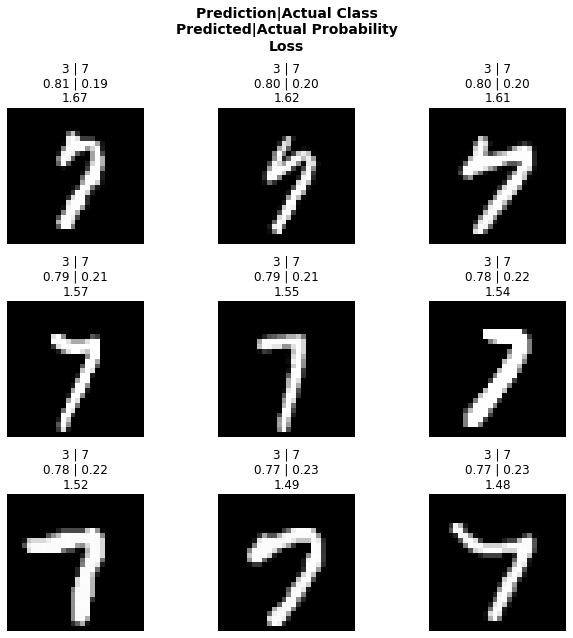

In [ ]:
plot_top_losses(x, y, decoded, interp.dl.vocab, preds, losses)

In [ ]:
if its is not None:
    plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses, **kwargs)
#TODO: figure out if this is needed
#its None means that a batch knows how to show itself as a whole, so we pass x, x1
#else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

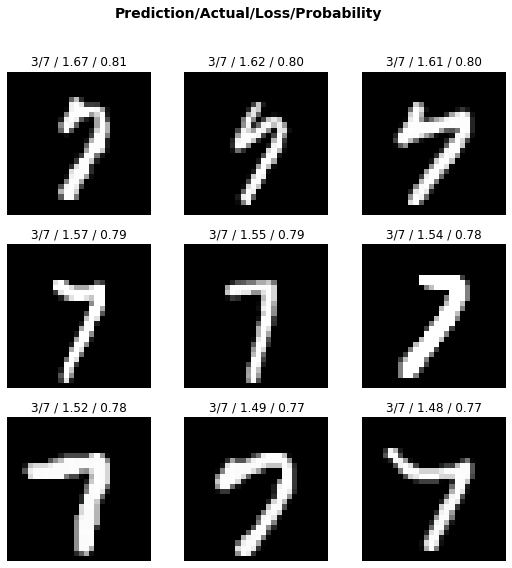

In [ ]:
interp.plot_top_losses(9)

In [ ]:
#hide
# verify stored losses equal calculated losses for idx
top_losses, idx = interp.top_losses(9)

dl = test_learner.dls[1].new(shuffle=False, drop_last=False)
items = getattr(dl.items, 'iloc', L(dl.items))[idx]
tmp_dl = test_learner.dls.test_dl(items, with_labels=True, process=not isinstance(dl, TabDataLoader))
_, _, _, _, losses = test_learner.get_preds(dl=tmp_dl, with_input=True, with_loss=True, 
                                            with_decoded=True, act=None, reorder=False)

test_close(top_losses, losses)

In [ ]:
#hide
#dummy test to ensure we can run on the training set
interp = Interpretation.from_learner(test_learner, ds_idx=0)
x, y, out = [], [], []
for batch in test_learner.dls.train.new(drop_last=False, shuffle=False):
    x += batch[0]
    y += batch[1]
    out += test_learner.model(batch[0])
x,y,out = torch.stack(x), torch.stack(y, dim=0), torch.stack(out, dim=0)
inps, preds, targs, decoded, losses = interp[:]
test_eq(inps, to_cpu(x))
test_eq(targs, to_cpu(y))
loss = torch.stack([test_learner.loss_func(p,t) for p,t in zip(out,y)], dim=0)
test_close(losses, to_cpu(loss))

In [ ]:
#export
class ClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."

    def __init__(self, learn, dl, losses, act=None):
        super().__init__(learn, dl, losses, act)
        self.vocab = self.dl.vocab
        if is_listy(self.vocab): self.vocab = self.vocab[-1]

    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`."
        x = torch.arange(0, len(self.vocab))
        _,targs,decoded = self.learn.get_preds(dl=self.dl, with_decoded=True, with_preds=True, 
                                               with_targs=True, act=self.act)
        d,t = flatten_check(decoded, targs)
        cm = ((d==x[:,None]) & (t==x[:,None,None])).long().sum(2)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2,
                              plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix()
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(self.vocab))
        plt.xticks(tick_marks, self.vocab, rotation=90)
        plt.yticks(tick_marks, self.vocab, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax = fig.gca()
        ax.set_ylim(len(self.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)

    def most_confused(self, min_val=1):
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix()
        np.fill_diagonal(cm, 0)
        res = [(self.vocab[i],self.vocab[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)

    def print_classification_report(self):
        "Print scikit-learn classification report"
        _,targs,decoded = self.learn.get_preds(dl=self.dl, with_decoded=True, with_preds=True, 
                                               with_targs=True, act=self.act)
        d,t = flatten_check(decoded, targs)
        print(skm.classification_report(t, d, labels=list(self.vocab.o2i.values()), target_names=[str(v) for v in self.vocab]))

In [ ]:
#hide
# simple test to make sure ClassificationInterpretation works
interp = ClassificationInterpretation.from_learner(test_learner)
cm = interp.confusion_matrix()

In [ ]:
#export
class SegmentationInterpretation(Interpretation):
    "Interpretation methods for segmentation models."
    pass

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 